# EfficientDet Tutorial: inference, eval, and training 



<table align="left"><td>
  <a target="_blank"  href="https://github.com/google/automl/blob/master/efficientdet/tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on github
  </a>
</td><td>
  <a target="_blank"  href="https://colab.sandbox.google.com/github/google/automl/blob/master/efficientdet/tutorial.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td></table>

# 0. Install and view graph.

## 0.1 Install package and download source code/image.



In [1]:
%%capture
#@title
import os
import sys
import tensorflow.compat.v1 as tf

# Download source code.
if "efficientdet" not in os.getcwd():
  !git clone --depth 1 https://github.com/google/automl
  os.chdir('automl/efficientdet')
  sys.path.append('.')
  !pip install -r requirements.txt
  !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
else:
  !git pull

In [2]:
MODEL = 'efficientdet-d0'  #@param

def download(m):
  if m not in os.listdir():
    !curl -O https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/{m}.tar.gz
    !tar zxf {m}.tar.gz
  ckpt_path = os.path.join(os.getcwd(), m)
  return ckpt_path

# Download checkpoint.
ckpt_path = download(MODEL)
print('Use model in {}'.format(ckpt_path))

# Prepare image and visualization settings.
# image_url =  'D:\codingan_serius\bachelor_thesis\Tensorflow\VisDrone2019-DET-train\images\'#@param
# image_name = '0000010_05149_d_0000057.jpg.png' #@param
#!wget {image_url} -O img.png
import os
#img_path = os.path.join(os.getcwd(), 'img.png')
img_path="D:/codingan_serius/bachelor_thesis/Tensorflow/VisDrone2019-DET-train/images/0000068_02104_d_0000006.jpg"

min_score_thresh = 0.15  #@param changed from 0.35
max_boxes_to_draw = 200  #@param
line_thickness =   2#@param

import PIL
# Get the largest of height/width and round to 128.
image_size = max(PIL.Image.open(img_path).size)

Use model in d:\codingan_serius\bachelor_thesis\colab\automl\efficientdet\efficientdet-d0


## 0.2 View graph in TensorBoard

In [25]:
# !tensorboard dev upload --logdir \
#     'd:/codingan_serius/bachelor_thesis'

^C


In [3]:
# !python model_inspect.py --model_name={MODEL} --logdir=logs &> /dev/null
# %load_ext tensorboard
# %tensorboard --logdir logs

The syntax of the command is incorrect.


Reusing TensorBoard on port 6006 (pid 12548), started 2 days, 15:42:15 ago. (Use '!kill 12548' to kill it.)

# 1. inference

## 1.1 Benchmark network latency
There are two types of latency:
network latency and end-to-end latency.

*   network latency: from the first conv op to the network class and box prediction.
*   end-to-end latency: from image preprocessing, network, to the final postprocessing to generate a annotated new image.


In [3]:
# benchmaak network latency
!python model_inspect.py --runmode=bm --model_name=efficientdet-d0 --hparams="mixed_precision=true"

# With colab + Tesla T4 GPU, here are the batch size 1 latency summary:
# D0 (AP=33.5):  14.9ms,  FPS = 67.2   (batch size 8 FPS=)
# D1 (AP=39.6):  22.7ms,  FPS = 44.1   (batch size 8 FPS=)
# D2 (AP=43.0):  27.9ms,  FPS = 35.8   (batch size 8 FPS=)
# D3 (AP=45.8):  48.1ms,  FPS = 20.8   (batch size 8 FPS=)
# D4 (AP=49.4):  81.9ms,  FPS = 12.2   (batch size 8 FPS=)

Start benchmark runs total=10
Per batch inference time:  0.057608850000000086
FPS:  17.358444058508347


2021-10-30 12:27:18.206795: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-30 12:27:19.540955: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3989 MB memory:  -> device: 0, name: GeForce GTX 1660 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5

W1030 12:27:20.354537 21964 module_wrapper.py:153] From d:\codingan_serius\bachelor_thesis\colab\automl\efficientdet\utils.py:601: The name tf.keras.layers.enable_v2_dtype_behavior is deprecated. Please use tf.compat.v1.keras.layers.enable_v2_dtype_behavior instead.

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
W1030 12:27:30.310802 219

## 1.2 Benchmark end-to-end latency

In [4]:
# Benchmark end-to-end latency (: preprocess + network + posprocess).
#
# With colab + Tesla T4 GPU, here are the batch size 1 latency summary:
# D0 (AP=33.5): 22.7ms,  FPS = 43.1   (batch size 4, FPS=)
# D1 (AP=39.6): 34.3ms,  FPS = 29.2   (batch size 4, FPS=)
# D2 (AP=43.0): 42.5ms,  FPS = 23.5   (batch size 4, FPS=)
# D3 (AP=45.8): 64.8ms,  FPS = 15.4   (batch size 4, FPS=)
# D4 (AP=49.4): 93.7ms,  FPS = 10.7   (batch size 4, FPS=)

m = 'efficientdet-d0'  # @param
batch_size = 1  # @param
m_path = download(m)

saved_model_dir = 'savedmodel'
!rd /s /q {saved_model_dir}
!python model_inspect.py --runmode=saved_model --model_name={m} \
  --ckpt_path={m_path} --saved_model_dir={saved_model_dir} \
  --batch_size={batch_size}  --hparams="mixed_precision=true"
!python model_inspect.py --runmode=saved_model_benchmark --model_name={m} \
  --ckpt_path={m_path} --saved_model_dir={saved_model_dir}/{m}_frozen.pb \
  --batch_size={batch_size}  --hparams="mixed_precision=true" --input_image=testdata/img1.jpg


2021-10-30 12:27:44.730833: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-30 12:27:45.299080: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3989 MB memory:  -> device: 0, name: GeForce GTX 1660 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5

W1030 12:27:46.042481 20816 module_wrapper.py:153] From d:\codingan_serius\bachelor_thesis\colab\automl\efficientdet\utils.py:601: The name tf.keras.layers.enable_v2_dtype_behavior is deprecated. Please use tf.compat.v1.keras.layers.enable_v2_dtype_behavior instead.

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager 

Per batch inference time:  0.06276010000000003
FPS:  15.933690354221863


2021-10-30 12:28:25.394646: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-30 12:28:26.029144: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3989 MB memory:  -> device: 0, name: GeForce GTX 1660 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5
2021-10-30 12:28:28.947352: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200


## 1.3 Inference images.

---



In [5]:
# first export a saved model.
saved_model_dir = 'savedmodel'
!rd /s /q {saved_model_dir}
!python model_inspect.py --runmode=saved_model --model_name={MODEL} \
  --ckpt_path={ckpt_path} --saved_model_dir={saved_model_dir}

# Then run saved_model_infer to do inference.
# Notably: batch_size, image_size must be the same as when it is exported.
serve_image_out = 'serve_image_out'
!mkdir {serve_image_out}

!python model_inspect.py --runmode=saved_model_infer \
  --saved_model_dir={saved_model_dir} \
  --model_name={MODEL}  --input_image=testdata/testagain.jpg  \
  --output_image_dir={serve_image_out} \
  --min_score_thresh={min_score_thresh}  --max_boxes_to_draw={max_boxes_to_draw}

2021-10-30 12:28:36.928058: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-30 12:28:37.549092: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3989 MB memory:  -> device: 0, name: GeForce GTX 1660 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5

W1030 12:28:38.270465  8540 module_wrapper.py:153] From d:\codingan_serius\bachelor_thesis\colab\automl\efficientdet\utils.py:601: The name tf.keras.layers.enable_v2_dtype_behavior is deprecated. Please use tf.compat.v1.keras.layers.enable_v2_dtype_behavior instead.

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager 

all_files= ['testdata\\testagain.jpg']
writing file to serve_image_out\0.jpg


2021-10-30 12:29:16.694771: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-30 12:29:17.269486: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3989 MB memory:  -> device: 0, name: GeForce GTX 1660 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
W1030 12:29:17.270360  2460 deprecation.py:339] From d:\codingan_serius\bachelor_thesis\colab\automl\efficientdet\inference.py:569: l

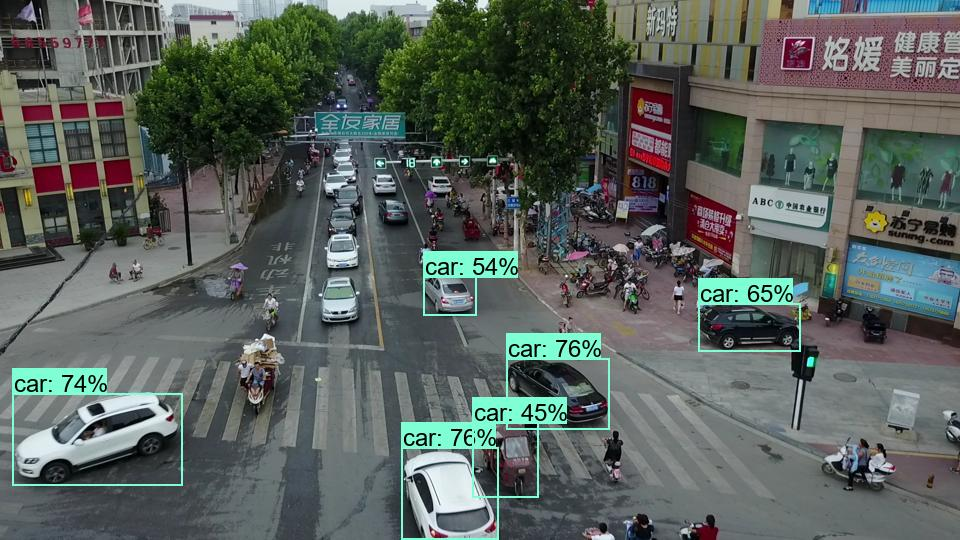

In [6]:
from IPython import display
display.display(display.Image(os.path.join(serve_image_out, '0.jpg')))

In [26]:
# # In case you need to specify different image size or batch size or #boxes, then
# # you need to export a new saved model and run the inferernce.

# serve_image_out = 'serve_image_out'
# !rd /s /q {serve_image_out}
# saved_model_dir = 'savedmodel'
# !rd /s /q {saved_model_dir}

# # Step 1: export model
# !python model_inspect.py --runmode=saved_model \
#   --model_name=efficientdet-d0 --ckpt_path=efficientdet-d0 \
#   --hparams="image_size=1920x1280" --saved_model_dir={saved_model_dir}

# # Step 2: do inference with saved model.
# !python model_inspect.py --runmode=saved_model_infer \
#   --model_name=efficientdet-d0 --saved_model_dir={saved_model_dir} \
#   --input_image=testagain.jpg --output_image_dir={serve_image_out} \
#   --min_score_thresh={min_score_thresh}  --max_boxes_to_draw={max_boxes_to_draw}

# from IPython import display
# display.display(display.Image(os.path.join(serve_image_out, '0.jpg')))

The system cannot find the file specified.
2021-10-28 17:07:40.747162: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-28 17:07:42.079392: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3989 MB memory:  -> device: 0, name: GeForce GTX 1660 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5

W1028 17:07:43.373433 11196 module_wrapper.py:153] From d:\codingan_serius\bachelor_thesis\colab\automl\efficientdet\utils.py:601: The name tf.keras.layers.enable_v2_dtype_behavior is deprecated. Please use tf.compat.v1.keras.layers.enable_v2_dtype_behavior instead.

Instructions for updating:
Use Variable.read_value. Variables in 2.X a

all_files= []


2021-10-28 17:09:13.307434: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-28 17:09:14.654115: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3989 MB memory:  -> device: 0, name: GeForce GTX 1660 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
W1028 17:09:14.656644  1860 deprecation.py:339] From d:\codingan_serius\bachelor_thesis\colab\automl\efficientdet\inference.py:569: l

FileNotFoundError: No such file or directory: 'serve_image_out\0.jpg'

FileNotFoundError: No such file or directory: 'serve_image_out\0.jpg'

<IPython.core.display.Image object>

## 1.4 Inference video

In [ ]:
# # step 0: download video
# video_url = 'https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/data/video480p.mov'  # @param
# !wget {video_url} -O input.mov

# # Step 1: export model
# saved_model_dir = 'savedmodel'
# !rm -rf {saved_model_dir}

# !python model_inspect.py --runmode=saved_model \
#   --model_name=efficientdet-d0 --ckpt_path=efficientdet-d0 \
#   --saved_model_dir={saved_model_dir} --hparams="mixed_precision=true"

# # Step 2: do inference with saved model using saved_model_video
# !python model_inspect.py --runmode=saved_model_video \
#   --model_name=efficientdet-d0   --ckpt_path=efficientdet-d0 \
#   --saved_model_dir={saved_model_dir} --hparams="mixed_precision=true" \
#   --input_video=input.mov --output_video=output.mov
# # Then you can view the output.mov

--2020-06-01 05:08:08--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/data/video480p.mov
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 2607:f8b0:400c:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18511760 (18M) [application/octet-stream]
Saving to: ‘input.mov’

input.mov           100%[===================>]  17.65M  --.-KB/s    in 0.1s    

2020-06-01 05:08:08 (119 MB/s) - ‘input.mov’ saved [18511760/18511760]

2020-06-01 05:08:10.640913: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-06-01 05:08:12.964736: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2300000000 Hz
2020-06-01 05:08:12.965102: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2c41480 initialized for platform Host (this does not guarantee t

# 3. COCO evaluation

## 3.1 COCO evaluation on validation set.

In [ ]:
if 'val2017' not in os.listdir():
  !wget http://images.cocodataset.org/zips/val2017.zip
  !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
  !unzip -q val2017.zip
  !unzip annotations_trainval2017.zip

  !mkdir tfrecord
  !PYTHONPATH=".:$PYTHONPATH"  python dataset/create_coco_tfrecord.py \
      --image_dir=val2017 \
      --caption_annotations_file=annotations/captions_val2017.json \
      --output_file_prefix=tfrecord/val \
      --num_shards=32

--2020-06-01 03:22:59--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.239.115
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.239.115|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  95.2MB/s    in 8.1s    

2020-06-01 03:23:07 (96.1 MB/s) - ‘val2017.zip’ saved [815585330/815585330]

--2020-06-01 03:23:08--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.163.67
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.163.67|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  96.2MB/s    in 2.5s    

2020

In [ ]:
# Evalute on validation set (takes about 10 mins for efficientdet-d0)
!python main.py --mode=eval  \
    --model_name={MODEL}  --model_dir={ckpt_path}  \
    --val_file_pattern=tfrecord/val*  \
    --val_json_file=annotations/instances_val2017.json

2020-06-01 03:28:25.377482: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1

W0601 03:28:27.532853 140219029243776 module_wrapper.py:138] From main.py:234: The name tf.estimator.tpu.TPUConfig is deprecated. Please use tf.compat.v1.estimator.tpu.TPUConfig instead.


W0601 03:28:27.533198 140219029243776 module_wrapper.py:138] From main.py:239: The name tf.estimator.tpu.InputPipelineConfig is deprecated. Please use tf.compat.v1.estimator.tpu.InputPipelineConfig instead.


W0601 03:28:27.533394 140219029243776 module_wrapper.py:138] From main.py:247: The name tf.estimator.tpu.RunConfig is deprecated. Please use tf.compat.v1.estimator.tpu.RunConfig instead.

I0601 03:28:27.533618 140219029243776 main.py:262] {'name': 'efficientdet-d0', 'act_type': 'swish', 'image_size': (512, 512), 'target_size': None, 'input_rand_hflip': True, 'train_scale_min': 0.1, 'train_scale_max': 2.0, 'autoaugment_policy': None, 'use_augmix': Fals

## 3.2 COCO evaluation on test-dev.

In [ ]:
# Eval on test-dev is slow (~40 mins), please be cautious. 
RUN_EXPENSIVE_TEST_DEV_EVAL = True  #@param

if RUN_EXPENSIVE_TEST_DEV_EVAL == True:
  !rm *.zip *.tar tfrecord/ val2017/   # Cleanup disk space
  # Download and convert test-dev data.
  if "test2017" not in os.listdir():
    !wget http://images.cocodataset.org/zips/test2017.zip
    !unzip -q test2017.zip
    !wget http://images.cocodataset.org/annotations/image_info_test2017.zip
    !unzip image_info_test2017.zip

    !mkdir tfrecord
    !PYTHONPATH=".:$PYTHONPATH"  python dataset/create_coco_tfrecord.py \
          --image_dir=test2017 \
          --image_info_file=annotations/image_info_test-dev2017.json \
          --output_file_prefix=tfrecord/testdev \
          --num_shards=32

  # Evalute on validation set: non-empty testdev_dir is the key pararmeter.
  # Also, test-dev has 20288 images rather than val 5000 images.
  !mkdir testdev_output
  !python main.py --mode=eval  \
      --model_name={MODEL}  --model_dir={ckpt_path}  \
      --val_file_pattern=tfrecord/testdev*  \
      --eval_batch_size=8  --eval_samples=20288 \
      --testdev_dir='testdev_output'
  !rm -rf test2017  # delete images to release disk space.
  # Now you can submit testdev_output/detections_test-dev2017_test_results.json to
  # coco server: https://competitions.codalab.org/competitions/20794#participate

# 4. Training EfficientDets on PASCAL.

## 4.1 Prepare data

In [18]:
# # Get pascal voc 2012 trainval data
# import os
# if 'VOCdevkit' not in os.listdir():
#   !curl -O http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
#   !tar zxf VOCtrainval_11-May-2012.tar

#   !mkdir tfrecord


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 1907M    0  275k    0     0   151k      0  3:35:10  0:00:01  3:35:09  151k
  0 1907M    0  853k    0     0   302k      0  1:47:29  0:00:02  1:47:27  302k
  0 1907M    0 1662k    0     0   435k      0  1:14:41  0:00:03  1:14:38  435k
  0 1907M    0 2557k    0     0   530k      0  1:01:18  0:00:04  1:01:14  530k
  0 1907M    0 3271k    0     0   562k      0  0:57:49  0:00:05  0:57:44  653k
  0 1907M    0 4011k    0     0   589k      0  0:55:14  0:00:06  0:55:08  748k
  0 1907M    0 4790k    0     0   613k      0  0:53:02  0:00:07  0:52:55  789k
  0 1907M    0 5571k    0     0   632k      0  0:51:26  0:00:08  0:51:18  783k
  0 1907M    0 6358k    0     0   648k      0  0:50

In [22]:
  # !python dataset/create_pascal_tfrecord.py  \
  #   --data_dir=VOCdevkit --year=VOC2012  --output_path=tfrecord/pascal

I1030 09:09:28.130800 11112 create_pascal_tfrecord.py:254] Writing to output directory: tfrecord
I1030 09:09:28.244809 11112 create_pascal_tfrecord.py:287] Reading from PASCAL VOC2012 dataset.
I1030 09:09:28.244809 11112 create_pascal_tfrecord.py:292] On image 0 of 5717
I1030 09:09:32.558188 11112 create_pascal_tfrecord.py:292] On image 100 of 5717
I1030 09:09:34.393006 11112 create_pascal_tfrecord.py:292] On image 200 of 5717
I1030 09:09:35.715521 11112 create_pascal_tfrecord.py:292] On image 300 of 5717
I1030 09:09:36.879272 11112 create_pascal_tfrecord.py:292] On image 400 of 5717
I1030 09:09:37.924289 11112 create_pascal_tfrecord.py:292] On image 500 of 5717
I1030 09:09:39.082328 11112 create_pascal_tfrecord.py:292] On image 600 of 5717
I1030 09:09:40.186328 11112 create_pascal_tfrecord.py:292] On image 700 of 5717
I1030 09:09:41.343090 11112 create_pascal_tfrecord.py:292] On image 800 of 5717
I1030 09:09:42.685288 11112 create_pascal_tfrecord.py:292] On image 900 of 5717
I1030 09:

In [11]:
# Pascal has 5717 train images with 100 shards epoch, here we use a single shard
# for demo, but users should use all shards pascal-*-of-00100.tfrecord.
file_pattern = 'pascal-00000-of-00100.tfrecord'  # @param
images_per_epoch = 57 * len(tf.io.gfile.glob('tfrecord/' + file_pattern))

# file_pattern = 'train.tfrecord'  # @param
# images_per_epoch = 57 * len(tf.io.gfile.glob('D:/codingan_serius/bachelor_thesis/Tensorflow/workspace/data/' + file_pattern))
images_per_epoch = images_per_epoch // 8 * 8  # round to 64.
print('images_per_epoch = {}'.format(images_per_epoch))

images_per_epoch = 56


## 4.2 Train Pascal VOC 2012 from ImageNet checkpoint for Backbone.

In [12]:
# Train efficientdet from scratch with backbone checkpoint.
backbone_name = {
    'efficientdet-d0': 'efficientnet-b0',
    'efficientdet-d1': 'efficientnet-b1',
    'efficientdet-d2': 'efficientnet-b2',
    'efficientdet-d3': 'efficientnet-b3',
    'efficientdet-d4': 'efficientnet-b4',
    'efficientdet-d5': 'efficientnet-b5',
    'efficientdet-d6': 'efficientnet-b6',
    'efficientdet-d7': 'efficientnet-b6',
}[MODEL]


# generating train tfrecord is large, so we skip the execution here.
import os
if backbone_name not in os.listdir():
  !curl -O https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/ckptsaug/{backbone_name}.tar.gz
  !tar zxf {backbone_name}.tar.gz

#file_pattern_new='D:/codingan_serius/bachelor_thesis/Tensorflow/workspace/data/train.tfrecord'

!mkdir /tmp/model_dir
# key option: use --backbone_ckpt rather than --ckpt.
# Don't use ema since we only train a few steps.
!python main.py --mode=train_and_eval \
    --train_file_pattern=tfrecord/{file_pattern} \
    --val_file_pattern=tfrecord/{file_pattern} \
    --model_name={MODEL} \
    --model_dir=/tmp/model_dir/{MODEL}-scratch  \
    --backbone_ckpt={backbone_name} \
    --train_batch_size=4 \
    --eval_batch_size=4 --eval_samples={images_per_epoch}  \
    --num_examples_per_epoch={images_per_epoch}  --num_epochs=2  \
    --hparams="num_classes=20,moving_average_decay=0,mixed_precision=true"

The syntax of the command is incorrect.



   =====> Starting training, epoch: 1.


I1030 12:38:13.193471 13156 main.py:228] {'name': 'efficientdet-d0', 'act_type': 'swish', 'image_size': (512, 512), 'target_size': None, 'input_rand_hflip': True, 'jitter_min': 0.1, 'jitter_max': 2.0, 'autoaugment_policy': None, 'grid_mask': False, 'sample_image': None, 'map_freq': 5, 'num_classes': 20, 'seg_num_classes': 3, 'heads': ['object_detection'], 'skip_crowd_during_training': True, 'label_map': None, 'max_instances_per_image': 100, 'regenerate_source_id': False, 'min_level': 3, 'max_level': 7, 'num_scales': 3, 'aspect_ratios': [1.0, 2.0, 0.5], 'anchor_scale': 4.0, 'is_training_bn': True, 'momentum': 0.9, 'optimizer': 'sgd', 'learning_rate': 0.08, 'lr_warmup_init': 0.008, 'lr_warmup_epoch': 1.0, 'first_lr_drop_epoch': 200.0, 'second_lr_drop_epoch': 250.0, 'poly_lr_power': 0.9, 'clip_gradients_norm': 10.0, 'num_epochs': 2, 'data_format': 'channels_last', 'mean_rgb': [123.675, 116.28, 103.53], 'stddev_rgb': [58.395, 57.120000000000005, 57.375], 'scale_range': False, 'label_smooth

## 4.3 Train PASCAL VOC 2012 from COCO checkpoint for the whole net.

In [27]:
# generating train tfrecord is large, so we skip the execution here.
import os
if MODEL not in os.listdir():
  !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/{MODEL}.tar.gz
  !tar xf {MODEL}.tar.gz

file_pattern_new='D:/codingan_serius/bachelor_thesis/Tensorflow/workspace/data/train.tfrecord'

!mkdir /tmp/model_dir/
# key option: use --ckpt rather than --backbone_ckpt.
!python main.py --mode=train_and_eval \
    --train_file_pattern=tfrecord/{file_pattern} \
    --val_file_pattern=tfrecord/{file_pattern} \
    --model_name={MODEL} \
    --model_dir=/tmp/model_dir/{MODEL}-finetune \
    --ckpt={MODEL} \
    --train_batch_size=8 \
    --eval_batch_size=8 --eval_samples={images_per_epoch}  \
    --num_examples_per_epoch={images_per_epoch}  --num_epochs=1  \
    --hparams="num_classes=20,moving_average_decay=0,mixed_precision=true"

    loss = self._train_model(input_fn, hooks, saving_listeners)
  File "C:\Users\igana\anaconda3\envs\skripsi\lib\site-packages\tensorflow_estimator\python\estimator\estimator.py", line 1176, in _train_model
    return self._train_model_default(input_fn, hooks, saving_listeners)
  File "C:\Users\igana\anaconda3\envs\skripsi\lib\site-packages\tensorflow_estimator\python\estimator\estimator.py", line 1207, in _train_model_default
    return self._train_with_estimator_spec(estimator_spec, worker_hooks,
  File "C:\Users\igana\anaconda3\envs\skripsi\lib\site-packages\tensorflow_estimator\python\estimator\estimator.py", line 1502, in _train_with_estimator_spec
    with training.MonitoredTrainingSession(
  File "C:\Users\igana\anaconda3\envs\skripsi\lib\site-packages\tensorflow\python\training\monitored_session.py", line 602, in MonitoredTrainingSession
    return MonitoredSession(
  File "C:\Users\igana\anaconda3\envs\skripsi\lib\site-packages\tensorflow\python\training\monitored_session.py"


   =====> Starting training, epoch: 1.


I1030 09:57:56.130227  3116 main.py:228] {'name': 'efficientdet-d0', 'act_type': 'swish', 'image_size': (512, 512), 'target_size': None, 'input_rand_hflip': True, 'jitter_min': 0.1, 'jitter_max': 2.0, 'autoaugment_policy': None, 'grid_mask': False, 'sample_image': None, 'map_freq': 5, 'num_classes': 20, 'seg_num_classes': 3, 'heads': ['object_detection'], 'skip_crowd_during_training': True, 'label_map': None, 'max_instances_per_image': 100, 'regenerate_source_id': False, 'min_level': 3, 'max_level': 7, 'num_scales': 3, 'aspect_ratios': [1.0, 2.0, 0.5], 'anchor_scale': 4.0, 'is_training_bn': True, 'momentum': 0.9, 'optimizer': 'sgd', 'learning_rate': 0.08, 'lr_warmup_init': 0.008, 'lr_warmup_epoch': 1.0, 'first_lr_drop_epoch': 200.0, 'second_lr_drop_epoch': 250.0, 'poly_lr_power': 0.9, 'clip_gradients_norm': 10.0, 'num_epochs': 1, 'data_format': 'channels_last', 'mean_rgb': [123.675, 116.28, 103.53], 'stddev_rgb': [58.395, 57.120000000000005, 57.375], 'scale_range': False, 'label_smooth

## 4.4 View tensorboard for loss and accuracy.


In [ ]:
%load_ext tensorboard
%tensorboard --logdir /tmp/model_dir/
# Notably, this is just a demo with almost zero accuracy due to very limited
# training steps, but we can see finetuning has smaller loss than training
# from scratch at the begining.

# 5. Start Trying to train on VisDrone

## 5.1 TFrecord prep

In [7]:
# Pascal has 5717 train images with 100 shards epoch, here we use a single shard
# for demo, but users should use all shards pascal-*-of-00100.tfrecord.
# file_pattern = 'pascal-00000-of-00100.tfrecord'  # @param
# images_per_epoch = 57 * len(tf.io.gfile.glob('tfrecord/' + file_pattern))

file_pattern = 'train.tfrecord'  # @param
images_per_epoch = 57 * len(tf.io.gfile.glob('D:/codingan_serius/bachelor_thesis/Tensorflow/workspace/data/' + file_pattern))
images_per_epoch = images_per_epoch // 8 * 8  # round to 64.
print('images_per_epoch = {}'.format(images_per_epoch))

images_per_epoch = 56


## 5.2 Train VisDrone from ImageNet checkpoint for Backbone.

In [8]:
# Train efficientdet from scratch with backbone checkpoint.
backbone_name = {
    'efficientdet-d0': 'efficientnet-b0',
    'efficientdet-d1': 'efficientnet-b1',
    'efficientdet-d2': 'efficientnet-b2',
    'efficientdet-d3': 'efficientnet-b3',
    'efficientdet-d4': 'efficientnet-b4',
    'efficientdet-d5': 'efficientnet-b5',
    'efficientdet-d6': 'efficientnet-b6',
    'efficientdet-d7': 'efficientnet-b6',
}[MODEL]


# generating train tfrecord is large, so we skip the execution here.
import os
if backbone_name not in os.listdir():
  !curl -O https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/ckptsaug/{backbone_name}.tar.gz
  !tar zxf {backbone_name}.tar.gz

file_pattern_new='D:/codingan_serius/bachelor_thesis/Tensorflow/workspace/data/train.tfrecord'

!mkdir /tmp/model_dir
# key option: use --backbone_ckpt rather than --ckpt.
# Don't use ema since we only train a few steps.
!python main.py --mode=train_and_eval \
    --train_file_pattern=tfrecord/{file_pattern_new} \
    --val_file_pattern=tfrecord/{file_pattern_new} \
    --model_name={MODEL} \
    --model_dir=/tmp/model_dir/{MODEL}-scratch  \
    --backbone_ckpt={backbone_name} \
    --train_batch_size=4 \
    --eval_batch_size=4 --eval_samples={images_per_epoch}  \
    --num_examples_per_epoch={images_per_epoch}  --num_epochs=2  \
    --hparams="num_classes=20,moving_average_decay=0,mixed_precision=true"

The syntax of the command is incorrect.



   =====> Starting training, epoch: 1.


I1030 12:35:36.162910 13004 main.py:228] {'name': 'efficientdet-d0', 'act_type': 'swish', 'image_size': (512, 512), 'target_size': None, 'input_rand_hflip': True, 'jitter_min': 0.1, 'jitter_max': 2.0, 'autoaugment_policy': None, 'grid_mask': False, 'sample_image': None, 'map_freq': 5, 'num_classes': 20, 'seg_num_classes': 3, 'heads': ['object_detection'], 'skip_crowd_during_training': True, 'label_map': None, 'max_instances_per_image': 100, 'regenerate_source_id': False, 'min_level': 3, 'max_level': 7, 'num_scales': 3, 'aspect_ratios': [1.0, 2.0, 0.5], 'anchor_scale': 4.0, 'is_training_bn': True, 'momentum': 0.9, 'optimizer': 'sgd', 'learning_rate': 0.08, 'lr_warmup_init': 0.008, 'lr_warmup_epoch': 1.0, 'first_lr_drop_epoch': 200.0, 'second_lr_drop_epoch': 250.0, 'poly_lr_power': 0.9, 'clip_gradients_norm': 10.0, 'num_epochs': 2, 'data_format': 'channels_last', 'mean_rgb': [123.675, 116.28, 103.53], 'stddev_rgb': [58.395, 57.120000000000005, 57.375], 'scale_range': False, 'label_smooth

## 5.3 Train VisDrone from COCO Checkpoint for the whole net

In [9]:
# generating train tfrecord is large, so we skip the execution here.
import os
if MODEL not in os.listdir():
  !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/{MODEL}.tar.gz
  !tar xf {MODEL}.tar.gz

file_pattern_new='D:/codingan_serius/bachelor_thesis/Tensorflow/workspace/data/train.tfrecord'

!mkdir /tmp/model_dir/
# key option: use --ckpt rather than --backbone_ckpt.
!python main.py --mode=train_and_eval \
    --train_file_pattern=tfrecord/{file_pattern_new} \
    --val_file_pattern=tfrecord/{file_pattern_new} \
    --model_name={MODEL} \
    --model_dir=/tmp/model_dir/{MODEL}-finetune \
    --ckpt={MODEL} \
    --train_batch_size=8 \
    --eval_batch_size=8 --eval_samples={images_per_epoch}  \
    --num_examples_per_epoch={images_per_epoch}  --num_epochs=1  \
    --hparams="num_classes=20,moving_average_decay=0,mixed_precision=true"


Errors may have originated from an input operation.
Input Source operations connected to node save/SaveV2:
 efficientnet-b0/blocks_5/tpu_batch_normalization/moving_variance/Read/ReadVariableOp (defined at d:\codingan_serius\bachelor_thesis\colab\automl\efficientdet\backbone\efficientnet_model.py:389)	
 fpn_cells/cell_0/fnode3/op_after_combine8/bn/beta/Read/ReadVariableOp (defined at d:\codingan_serius\bachelor_thesis\colab\automl\efficientdet\tf2\efficientdet_keras.py:228)	
 fpn_cells/cell_1/fnode7/op_after_combine12/conv/pointwise_kernel/Read/ReadVariableOp (defined at d:\codingan_serius\bachelor_thesis\colab\automl\efficientdet\tf2\efficientdet_keras.py:227)	
 fpn_cells/cell_1/fnode3/WSM_1/Momentum/Read/ReadVariableOp (defined at d:\codingan_serius\bachelor_thesis\colab\automl\efficientdet\det_model_fn.py:414)	
 box_net/box-2-bn-6/gamma/Read/ReadVariableOp (defined at d:\codingan_serius\bachelor_thesis\colab\automl\efficientdet\tf2\efficientdet_keras.py:599)	
 fpn_cells/cell_0/fnode


   =====> Starting training, epoch: 1.


I1030 12:36:34.097140  3396 main.py:228] {'name': 'efficientdet-d0', 'act_type': 'swish', 'image_size': (512, 512), 'target_size': None, 'input_rand_hflip': True, 'jitter_min': 0.1, 'jitter_max': 2.0, 'autoaugment_policy': None, 'grid_mask': False, 'sample_image': None, 'map_freq': 5, 'num_classes': 20, 'seg_num_classes': 3, 'heads': ['object_detection'], 'skip_crowd_during_training': True, 'label_map': None, 'max_instances_per_image': 100, 'regenerate_source_id': False, 'min_level': 3, 'max_level': 7, 'num_scales': 3, 'aspect_ratios': [1.0, 2.0, 0.5], 'anchor_scale': 4.0, 'is_training_bn': True, 'momentum': 0.9, 'optimizer': 'sgd', 'learning_rate': 0.08, 'lr_warmup_init': 0.008, 'lr_warmup_epoch': 1.0, 'first_lr_drop_epoch': 200.0, 'second_lr_drop_epoch': 250.0, 'poly_lr_power': 0.9, 'clip_gradients_norm': 10.0, 'num_epochs': 1, 'data_format': 'channels_last', 'mean_rgb': [123.675, 116.28, 103.53], 'stddev_rgb': [58.395, 57.120000000000005, 57.375], 'scale_range': False, 'label_smooth

In [10]:
%load_ext tensorboard
%tensorboard --logdir /tmp/model_dir/
# Notably, this is just a demo with almost zero accuracy due to very limited
# training steps, but we can see finetuning has smaller loss than training
# from scratch at the begining.

    return self._train_model_default(input_fn, hooks, saving_listeners)
  File "C:\Users\igana\anaconda3\envs\skripsi\lib\site-packages\tensorflow_estimator\python\estimator\estimator.py", line 1207, in _train_model_default
    return self._train_with_estimator_spec(estimator_spec, worker_hooks,
  File "C:\Users\igana\anaconda3\envs\skripsi\lib\site-packages\tensorflow_estimator\python\estimator\estimator.py", line 1502, in _train_with_estimator_spec
    with training.MonitoredTrainingSession(
  File "C:\Users\igana\anaconda3\envs\skripsi\lib\site-packages\tensorflow\python\training\monitored_session.py", line 602, in MonitoredTrainingSession
    return MonitoredSession(
  File "C:\Users\igana\anaconda3\envs\skripsi\lib\site-packages\tensorflow\python\training\monitored_session.py", line 1035, in __init__
    super(MonitoredSession, self).__init__(
  File "C:\Users\igana\anaconda3\envs\skripsi\lib\site-packages\tensorflow\python\training\monitored_session.py", line 750, in __init__
   